In [6]:
import uproot
import awkward as ak
from uproot_methods import TLorentzVectorArray
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

from coffea.nanoaod import NanoEvents
import time

In [2]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np


class HHProcessor(processor.ProcessorABC):
    def __init__(self):

        self._accumulator = processor.dict_accumulator({
            'templates': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pt1', r'Jet 1 $p_{T}$ [GeV]', [300, 400, 500, 600, 800, 1200]),
                hist.Bin('pt2', r'Jet 2 $p_{T}$ [GeV]', [300, 400, 500, 600, 800, 1200]),
                hist.Bin('mass1', r'Jet 1 $m_{SD}$ [GeV]', 10, 110, 150),
                hist.Bin('mass2', r'Jet 2 $m_{SD}$ [GeV]', 10, 110, 150),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        
        output = self.accumulator.identity()
        
        selection = processor.PackedSelection()
        weights = processor.Weights(len(events))
        weights.add('genweight', 137e3*events['weight'])

        dataset = events['dataset']
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            events['nFatJet'],
            pt=events['FatJet_pt'],
            eta=events['FatJet_eta'],
            phi=events['FatJet_phi'],
            mass=events['FatJet_msoftdrop'],
            bbtag=events['FatJet_btagDDBvL'],
            wwtag=events['FatJet_deepTagMDHqqqq']
            )

        candidatejets = fatjets[
            (fatjets.pt > 300)
            & (abs(fatjets.eta) < 2.5)
             & (fatjets.mass > 110.)
             & (fatjets.mass < 150.)
             & (fatjets.bbtag > 0.9)
        ]
        
        selection.add('twojets', (candidatejets.counts>=2))
        
        twojets = candidatejets.distincts(nested=True)

        leadingbbi0 = (twojets.i0.bbtag.content > twojets.i1.bbtag.content)
        
        bbjet1 = JaggedArray.fromoffsets(twojets.offsets, np.where(leadingbbi0,
                                                                    twojets.i0.bbtag.content, twojets.i1.bbtag.content))
        mass1 = JaggedArray.fromoffsets(twojets.offsets, np.where(leadingbbi0,
                                                                    twojets.i0.mass.content, twojets.i1.mass.content))
        pt1 = JaggedArray.fromoffsets(twojets.offsets, np.where(leadingbbi0,
                                                                    twojets.i0.pt.content, twojets.i1.pt.content))

        bbjet2 = JaggedArray.fromoffsets(twojets.offsets, np.where(~leadingbbi0,
                                                                    twojets.i0.bbtag.content, twojets.i1.bbtag.content))
        mass2 = JaggedArray.fromoffsets(twojets.offsets, np.where(~leadingbbi0,
                                                                    twojets.i0.mass.content, twojets.i1.mass.content))
        pt2 = JaggedArray.fromoffsets(twojets.offsets, np.where(~leadingbbi0,
                                                                    twojets.i0.pt.content, twojets.i1.pt.content))

        regions = {
            'bbbb': ['twojets']
        }
        
        
        def normalize(val, cut):
            return val[cut].pad(1, clip=True).fillna(0).flatten()
        
        def concat(val, cut):
            try:
                return np.concatenate(val[cut].flatten()).ravel()
            except:
                return np.array([])
            
        
        for region in regions:
            selections = regions[region]
            cut = selection.all(*selections)
            weight = weights.weight()[cut]

            output['templates'].fill(
                dataset=dataset,
                region=region,
                pt1=concat(pt1, cut),
                pt2=concat(pt2, cut),
                mass1=concat(mass1, cut),
                mass2=concat(mass2, cut),
                weight=weight,
            )

        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
tstart = time.time()

import glob
qcd = glob.glob('/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_*.root')
hh = glob.glob('/eos/uscms/store/user/jduarte1/ggHH_toBBBB_cit_tier_1pb_weighted*.root')
print(qcd)
qcd.pop(5)
print(qcd)
print(hh)

fileset = {
    'QCD': qcd,
    'HHToBBBBB': hh
}

output = processor.run_uproot_job(fileset,
                                  treename='hh',
                                  processor_instance=HHProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=5000,
                                 )

elapsed = time.time() - tstart
print(elapsed)

['/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht1000to1500_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht1500to2000_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht2000toInf_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht300to500_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht500to700_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht50to100_skim_all_1pb_weighted_TwoTagSkim.root', '/eos/uscms//store/group/lpchbb/LLDJntuples/cmorgoth/SkimNtuple_v1_sixie/diHiggs_output_qcd_ht700to1000_skim_all_1pb_weighted_TwoTagSkim.


2.7166500091552734


389.1909644603729
5.052898526191711


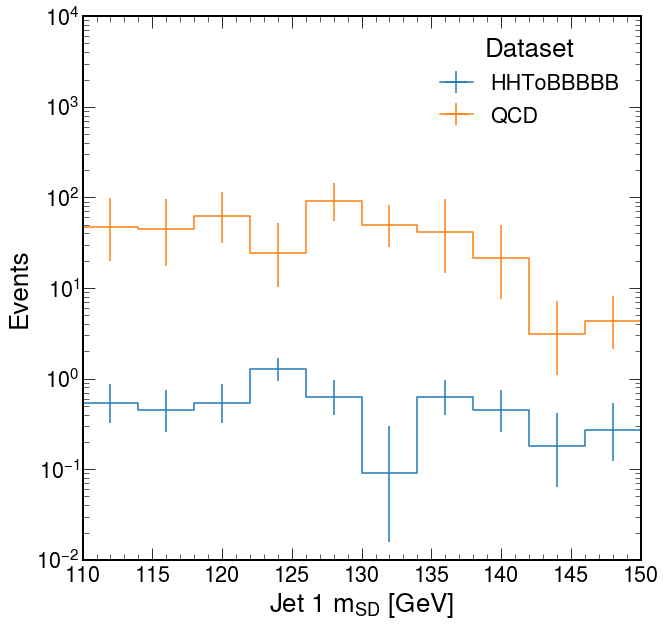

In [7]:
myhist1 = output['templates'].project('dataset','mass1')


ax = hist.plot1d(myhist1,overlay='dataset')
ax.set_ylim(0.01,10000)
ax.semilogy()

qcd = myhist1.values()[('QCD',)].sum()
hh = myhist1.values()[('HHToBBBBB',)].sum()

print(qcd)
print(hh)

389.1909644603729
5.052898526191711


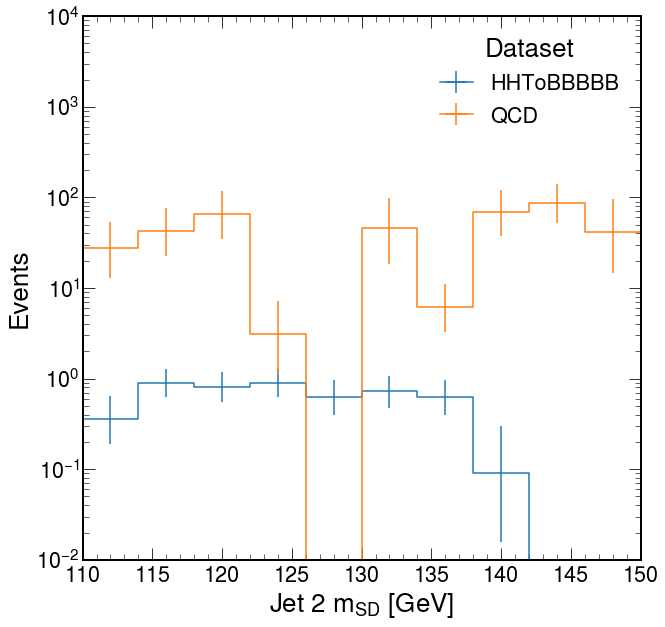

In [8]:
myhist2 = output['templates'].project('dataset','mass2')

ax = hist.plot1d(myhist2,overlay='dataset')
ax.set_ylim(0.01,10000)
ax.semilogy()

qcd = myhist2.values()[('QCD',)].sum()
hh = myhist2.values()[('HHToBBBBB',)].sum()

print(qcd)
print(hh)